# Advanced Machine Learning

### Assigment #6 - Deep Learning (Tensorflow image classification)

**Team:**
    João Raimundo (57454), Rui Roque (57588)

Disclaimer: [Problem 1](#Problem) starts at section 2.

### 0.1. Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

### 0.2. Download and explore the dataset

The dataset contains 3,670 photos of flowers, with five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 5s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total Images Downloaded:", image_count)

Total Images Downloaded: 3670


Here are some roses:

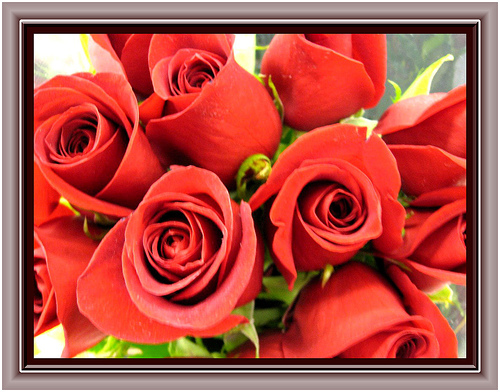

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

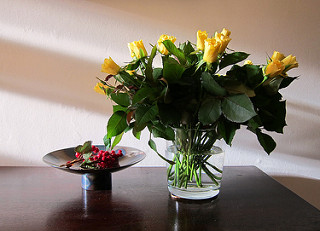

In [ ]:
PIL.Image.open(str(roses[1]))

And some tulips:

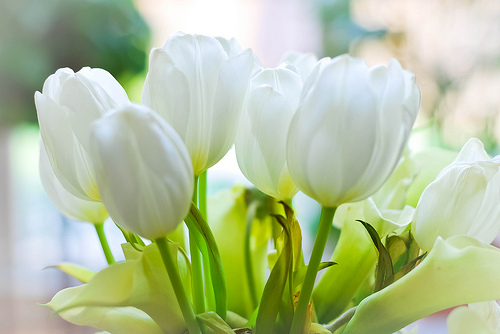

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

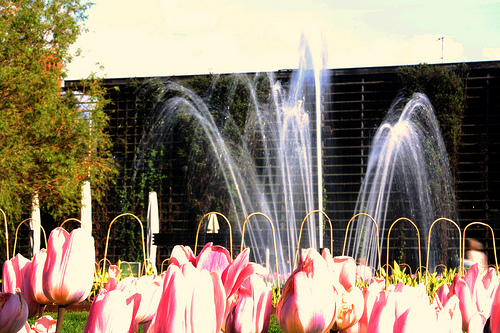

In [ ]:
PIL.Image.open(str(tulips[1]))

### 0.3. Create a dataset

Defining some parameters for the loader:

In [ ]:
batch_size = 32

# image size
img_height = 180
img_width = 180

It's good practice to use a validation split when developing the model. We use 80% of the images for training, and 20% for validation.

In [ ]:
# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# print class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 0.4. Visualize the data

Here are the first nine images from the training dataset for each class:

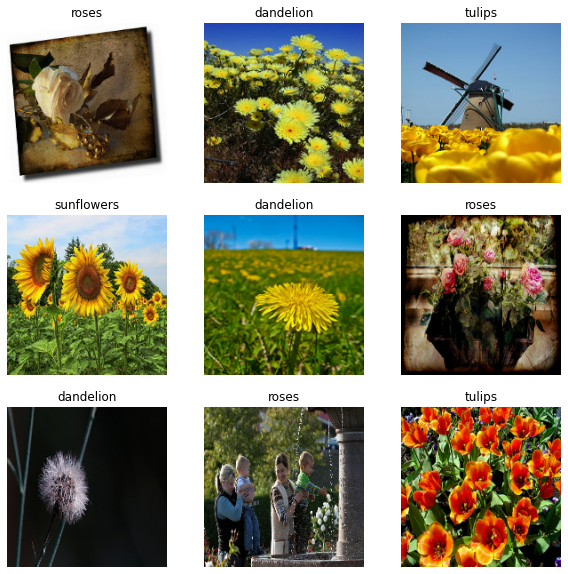

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

 Manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### 0.5. Configure the dataset for performance

These are two important methods that we should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 0.6. Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

We standardized values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [3]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. We applied it to the dataset by calling `Dataset.map`:

In [ ]:
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(norm_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [ ]:
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(norm_val_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.94418466


Or, we can include the layer inside your model definition, which can simplify deployment. Thus, we used the second approach here:

### 0.7. Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 0.7. Compile the model

To compile the model we used `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, we pass the `accuracy metric` argument to `model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 0.8. Model summary

Viewing all the layers of the network:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### 0.9. Train the model without overfitting control

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 16s 64ms/step - loss: 1.3096 - accuracy: 0.4496 - val_loss: 1.0867 - val_accuracy: 0.5545
Epoch 2/10
92/92 [==============================] - 4s 46ms/step - loss: 1.0070 - accuracy: 0.5984 - val_loss: 0.9974 - val_accuracy: 0.5926
Epoch 3/10
92/92 [==============================] - 4s 45ms/step - loss: 0.8110 - accuracy: 0.6751 - val_loss: 0.8603 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 4s 45ms/step - loss: 0.6191 - accuracy: 0.7636 - val_loss: 0.8573 - val_accuracy: 0.6608
Epoch 5/10
92/92 [==============================] - 4s 45ms/step - loss: 0.4088 - accuracy: 0.8573 - val_loss: 1.0916 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 4s 45ms/step - loss: 0.2343 - accuracy: 0.9193 - val_loss: 1.2136 - val_accuracy: 0.6662
Epoch 7/10
92/92 [==============================] - 4s 45ms/step - loss: 0.1237 - accuracy: 0.9612 - val_loss: 1.4472 - val_accuracy: 0.6362
Epoch 8/10
9

### 0.10 Visualize training results

Create plots of loss and accuracy on the training and validation sets:

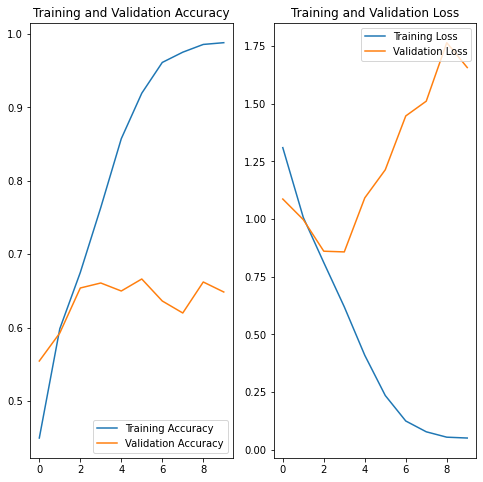

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

### 0.11 Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In the next steps we applied *data augmentation* and add *Dropout* to the model.

## 1. Base Model

### 1.1. Overfitting Control

### 1.1.1. Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from the existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We implemented data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside the model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualization of what a few augmented examples look like by applying data augmentation to the same image several times:

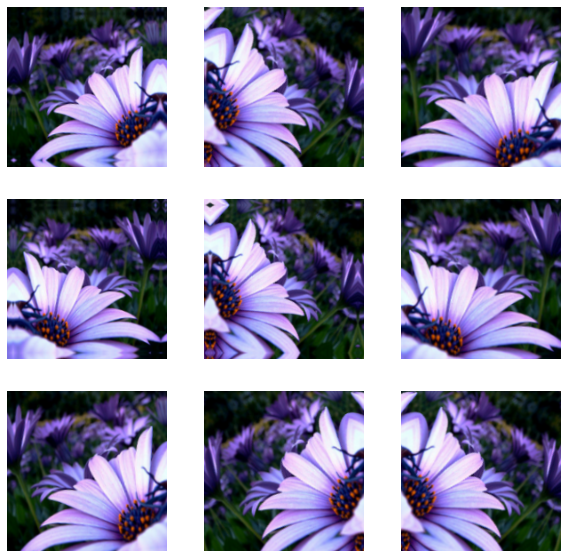

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We will use data augmentation to train a model.

### 1.1.2. Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When we apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

We create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 1.2. Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
# model fitting 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 55ms/step - loss: 1.3874 - accuracy: 0.3941 - val_loss: 1.3891 - val_accuracy: 0.4632
Epoch 2/15
92/92 [==============================] - 5s 52ms/step - loss: 1.0645 - accuracy: 0.5623 - val_loss: 0.9429 - val_accuracy: 0.6076
Epoch 3/15
92/92 [==============================] - 5s 52ms/step - loss: 0.9506 - accuracy: 0.6294 - val_loss: 1.0267 - val_accuracy: 0.6063
Epoch 4/15
92/92 [==============================] - 5s 51ms/step - loss: 0.8939 - accuracy: 0.6587 - val_loss: 0.9142 - val_accuracy: 0.6376
Epoch 5/15
92/92 [==============================] - 5s 52ms/step - loss: 0.8255 - accuracy: 0.6781 - val_loss: 0.8392 - val_accuracy: 0.6853
Epoch 6/15
92/92 [==============================] - 5s 52ms/step - loss: 0.7682 - accuracy: 0.7061 - val_loss: 0.7992 - val_accuracy: 0.7057
Epoch 7/15
92/92 [==============================] - 5s 52ms/step - loss: 0.7355 - accuracy: 0.7183 - val_loss: 0.8032 - val_accuracy: 0.7098
Epoch 8/15
92

### 1.3 Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

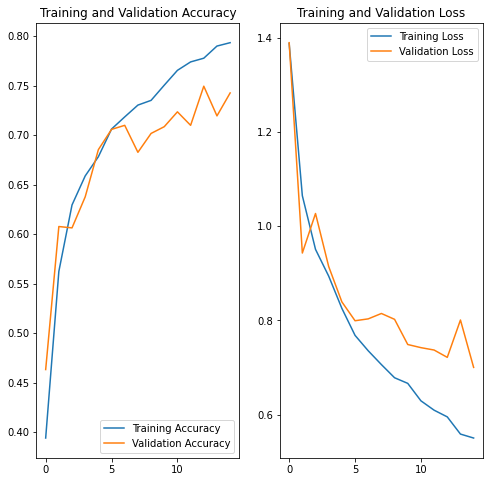

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 1.4. Predict on new data

Finally, we use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("\n")
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 0us/step


This image most likely belongs to sunflowers with a 88.98 percent confidence.


<a class="anchor" id="Problem"></a>
## 2. Problem 1


Create 4 different models, one at a time, by modifying the base model in the following manner:

 * I) Using the mean squared error as a loss function.
 * II) Using a dropout probability of 40%.
 * III) Using a batch size of 8.
 * IV) Using batch normalization.
 * V) Combine modifications II, III and IV.

### Defining Functions

In [ ]:
def plot_acc_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## I) Using the mean squared error as a loss function.

In [ ]:
# create model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# compile model using MeanSquaredError
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
# model fitting
epochs = 15
history_msl = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 7s 63ms/step - loss: 2.3183 - accuracy: 0.1832 - val_loss: 1.4547 - val_accuracy: 0.1853
Epoch 2/15
92/92 [==============================] - 6s 63ms/step - loss: 1.4940 - accuracy: 0.2081 - val_loss: 1.2821 - val_accuracy: 0.1744
Epoch 3/15
92/92 [==============================] - 5s 56ms/step - loss: 1.3001 - accuracy: 0.1938 - val_loss: 1.1911 - val_accuracy: 0.1785
Epoch 4/15
92/92 [==============================] - 5s 53ms/step - loss: 1.2288 - accuracy: 0.1866 - val_loss: 1.2530 - val_accuracy: 0.1376
Epoch 5/15
92/92 [==============================] - 5s 53ms/step - loss: 1.1558 - accuracy: 0.1706 - val_loss: 1.1202 - val_accuracy: 0.2343
Epoch 6/15
92/92 [==============================] - 5s 52ms/step - loss: 1.1226 - accuracy: 0.1877 - val_loss: 1.0467 - val_accuracy: 0.1362
Epoch 7/15
92/92 [==============================] - 5s 52ms/step - loss: 1.0681 - accuracy: 0.1921 - val_loss: 1.1003 - val_accuracy: 0.2275
Epoch 8/15
92

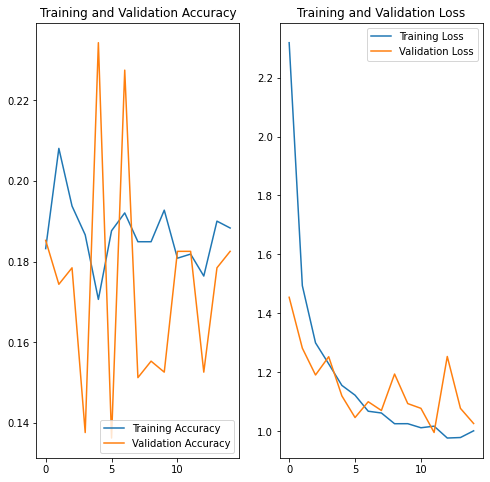

In [ ]:
plot_acc_loss(history_msl)

## II) Using a dropout probability of 40%.

In [ ]:
# create model with 40% dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# model compile using SparseCategoricalCrossentropy as loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [ ]:
# model fitting
epochs = 15
history_drop40 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 54ms/step - loss: 1.3173 - accuracy: 0.4380 - val_loss: 1.1960 - val_accuracy: 0.4946
Epoch 2/15
92/92 [==============================] - 5s 52ms/step - loss: 1.0424 - accuracy: 0.5828 - val_loss: 1.0486 - val_accuracy: 0.5668
Epoch 3/15
92/92 [==============================] - 5s 51ms/step - loss: 0.9608 - accuracy: 0.6206 - val_loss: 1.0640 - val_accuracy: 0.6008
Epoch 4/15
92/92 [==============================] - 5s 52ms/step - loss: 0.8942 - accuracy: 0.6502 - val_loss: 0.9280 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 5s 52ms/step - loss: 0.8459 - accuracy: 0.6740 - val_loss: 0.8809 - val_accuracy: 0.6812
Epoch 6/15
92/92 [==============================] - 5s 55ms/step - loss: 0.8063 - accuracy: 0.6815 - val_loss: 0.8627 - val_accuracy: 0.6730
Epoch 7/15
92/92 [==============================] - 5s 52ms/step - loss: 0.7714 - accuracy: 0.6996 - val_loss: 0.8356 - val_accuracy: 0.6839
Epoch 8/15
92

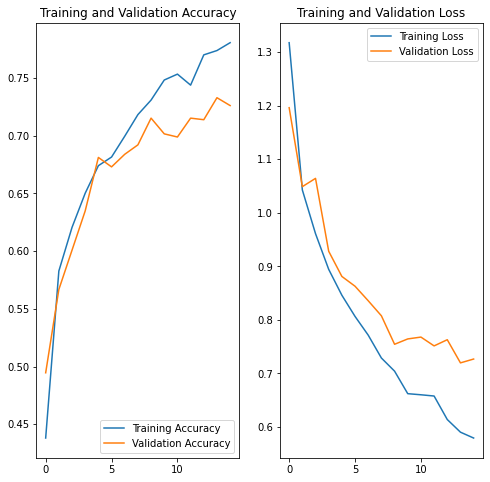

In [ ]:
plot_acc_loss(history_drop40)

## III) Using a batch size of 8

In [ ]:
batch_size = 8 # set batch value as 8
img_height = 180
img_width = 180

### Split training and validation set:

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Performance Configuration

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create Model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Model Fitting

In [ ]:
epochs=15
history_batch8 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
367/367 [==============================] - 14s 23ms/step - loss: 1.2785 - accuracy: 0.4663 - val_loss: 1.0249 - val_accuracy: 0.5995
Epoch 2/15
367/367 [==============================] - 7s 19ms/step - loss: 1.0006 - accuracy: 0.6090 - val_loss: 0.9919 - val_accuracy: 0.5967
Epoch 3/15
367/367 [==============================] - 7s 20ms/step - loss: 0.8911 - accuracy: 0.6580 - val_loss: 0.9167 - val_accuracy: 0.6662
Epoch 4/15
367/367 [==============================] - 7s 20ms/step - loss: 0.8170 - accuracy: 0.6866 - val_loss: 0.8178 - val_accuracy: 0.6771
Epoch 5/15
367/367 [==============================] - 7s 20ms/step - loss: 0.7515 - accuracy: 0.7149 - val_loss: 0.7762 - val_accuracy: 0.6989
Epoch 6/15
367/367 [==============================] - 7s 19ms/step - loss: 0.7331 - accuracy: 0.7139 - val_loss: 0.7462 - val_accuracy: 0.7003
Epoch 7/15
367/367 [==============================] - 7s 20ms/step - loss: 0.6810 - accuracy: 0.7364 - val_loss: 0.7569 - val_accuracy: 0.712

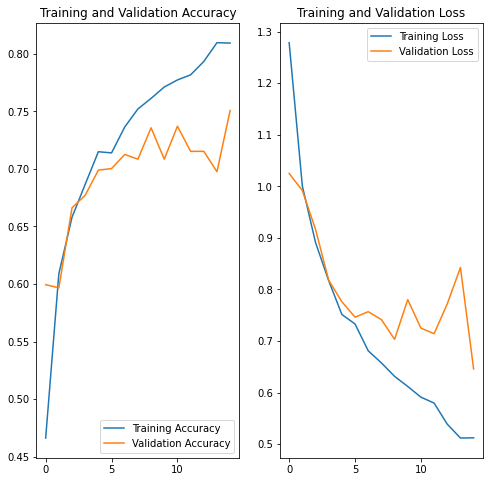

In [ ]:
plot_acc_loss(history_batch8)

## IV) Using batch normalization 

In [ ]:
# set batch size
batch_size = 8

In [ ]:
# define train set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# define validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# config performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Applying Batch Normalization to the model:

In [ ]:
# defining the model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])

In [ ]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 16)      

In [ ]:
# model fitting
epochs = 15
history_batchNormalization = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
367/367 [==============================] - 16s 27ms/step - loss: 1.3645 - accuracy: 0.4782 - val_loss: 1.5540 - val_accuracy: 0.3787
Epoch 2/15
367/367 [==============================] - 9s 23ms/step - loss: 1.0820 - accuracy: 0.5749 - val_loss: 1.1160 - val_accuracy: 0.5872
Epoch 3/15
367/367 [==============================] - 9s 23ms/step - loss: 0.9783 - accuracy: 0.6117 - val_loss: 1.2030 - val_accuracy: 0.5681
Epoch 4/15
367/367 [==============================] - 9s 23ms/step - loss: 0.9352 - accuracy: 0.6294 - val_loss: 1.4424 - val_accuracy: 0.5218
Epoch 5/15
367/367 [==============================] - 9s 23ms/step - loss: 0.8657 - accuracy: 0.6689 - val_loss: 1.1417 - val_accuracy: 0.5817
Epoch 6/15
367/367 [==============================] - 9s 23ms/step - loss: 0.8150 - accuracy: 0.6965 - val_loss: 1.0822 - val_accuracy: 0.6308
Epoch 7/15
367/367 [==============================] - 9s 23ms/step - loss: 0.7778 - accuracy: 0.7013 - val_loss: 1.3417 - val_accuracy: 0.566

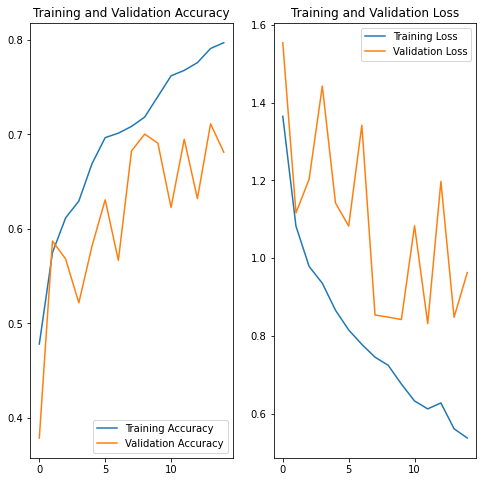

In [ ]:
plot_acc_loss(history_batchNormalization)

## V) Combine modifications II, III and IV.

In [ ]:
batch_size = 8 # set batch size to 8

img_height = 180
img_width = 180

In [ ]:
# define training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# define validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# config performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Configure the model with Dropout = 40% and Batch Normalization

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])

In [ ]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_7 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 90, 90, 16)      

In [ ]:
# model fitting
epochs=15
history_combined = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
367/367 [==============================] - 16s 26ms/step - loss: 1.3401 - accuracy: 0.4837 - val_loss: 2.2582 - val_accuracy: 0.2834
Epoch 2/15
367/367 [==============================] - 9s 23ms/step - loss: 1.0702 - accuracy: 0.5869 - val_loss: 1.1686 - val_accuracy: 0.5599
Epoch 3/15
367/367 [==============================] - 8s 23ms/step - loss: 1.0080 - accuracy: 0.6059 - val_loss: 1.3502 - val_accuracy: 0.5027
Epoch 4/15
367/367 [==============================] - 9s 23ms/step - loss: 0.9163 - accuracy: 0.6400 - val_loss: 1.0447 - val_accuracy: 0.5967
Epoch 5/15
367/367 [==============================] - 8s 23ms/step - loss: 0.8822 - accuracy: 0.6649 - val_loss: 1.3918 - val_accuracy: 0.5163
Epoch 6/15
367/367 [==============================] - 8s 23ms/step - loss: 0.8248 - accuracy: 0.6829 - val_loss: 0.9737 - val_accuracy: 0.6431
Epoch 7/15
367/367 [==============================] - 8s 23ms/step - loss: 0.7800 - accuracy: 0.7023 - val_loss: 0.9102 - val_accuracy: 0.658

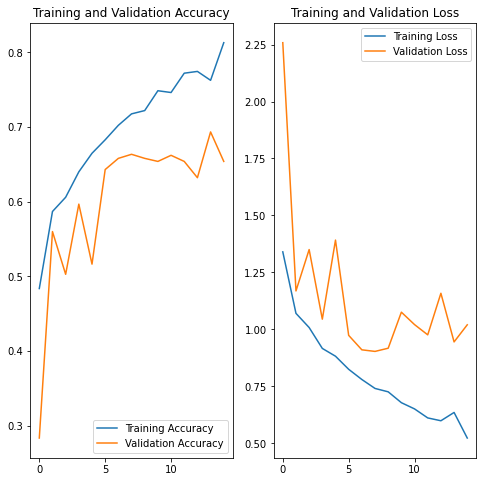

In [ ]:
plot_acc_loss(history_combined)

## Final Results

### Accuracy

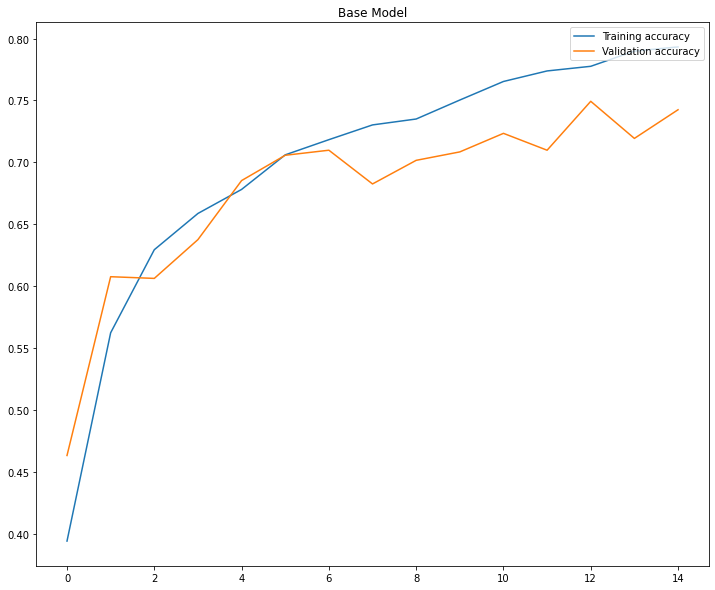

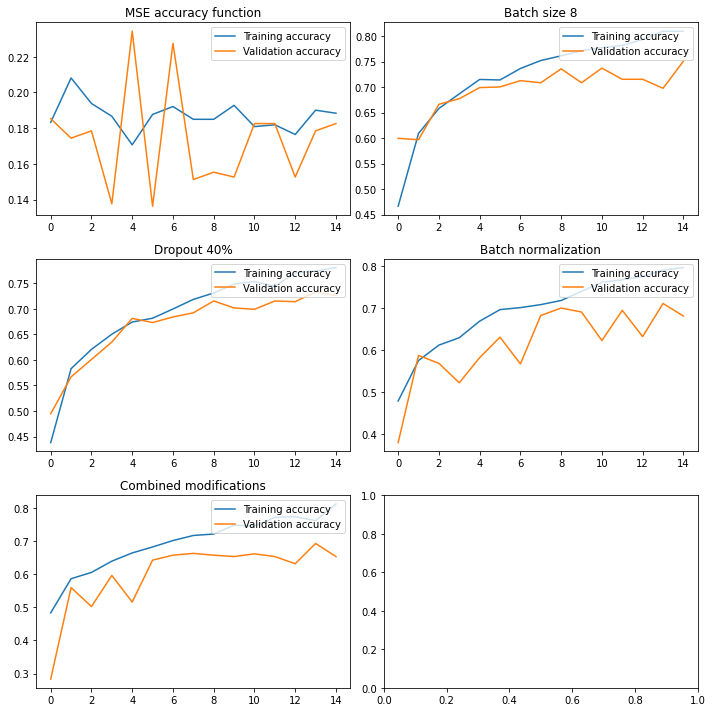

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

accuracy_base = history.history['accuracy']
val_accuracy_base = history.history['val_accuracy']

accuracy_mse = history_msl.history['accuracy']
val_accuracy_mse = history_msl.history['val_accuracy']

accuracy_drop40 = history_drop40.history['accuracy']
val_accuracy_drop40 = history_drop40.history['val_accuracy']

accuracy_batch8 = history_batch8.history['accuracy']
val_accuracy_batch8 = history_batch8.history['val_accuracy']

accuracy_batchNormalization = history_batchNormalization.history['accuracy']
val_accuracy_batchNormalization = history_batchNormalization.history['val_accuracy']

accuracy_combined = history_combined.history['accuracy']
val_accuracy_combined = history_combined.history['val_accuracy']


plt.figure(figsize=(26.5, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy_base, label='Training accuracy')
plt.plot(epochs_range, val_accuracy_base, label='Validation accuracy')
plt.legend(loc='upper right')
plt.title('Base Model')

fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(epochs_range, accuracy_mse, label='Training accuracy')
axs[0, 0].plot(epochs_range, val_accuracy_mse, label='Validation accuracy')
axs[0, 0].set_title("MSE accuracy function")
axs[0, 0].legend(loc='upper right')
axs[1, 0].plot(epochs_range, accuracy_drop40, label='Training accuracy')
axs[1, 0].plot(epochs_range, val_accuracy_drop40, label='Validation accuracy')
axs[1, 0].set_title("Dropout 40%")
axs[1, 0].legend(loc='upper right')
axs[0, 1].plot(epochs_range, accuracy_batch8, label='Training accuracy')
axs[0, 1].plot(epochs_range, val_accuracy_batch8, label='Validation accuracy')
axs[0, 1].set_title("Batch size 8")
axs[0, 1].legend(loc='upper right')
axs[1, 1].plot(epochs_range, accuracy_batchNormalization, label='Training accuracy')
axs[1, 1].plot(epochs_range, val_accuracy_batchNormalization, label='Validation accuracy')
axs[1, 1].set_title("Batch normalization")
axs[1, 1].legend(loc='upper right')
axs[2, 0].plot(epochs_range, accuracy_combined, label='Training accuracy')
axs[2, 0].plot(epochs_range, val_accuracy_combined, label='Validation accuracy')
axs[2, 0].set_title("Combined modifications")
axs[2,0].legend(loc='upper right')
fig.tight_layout()

### Loss

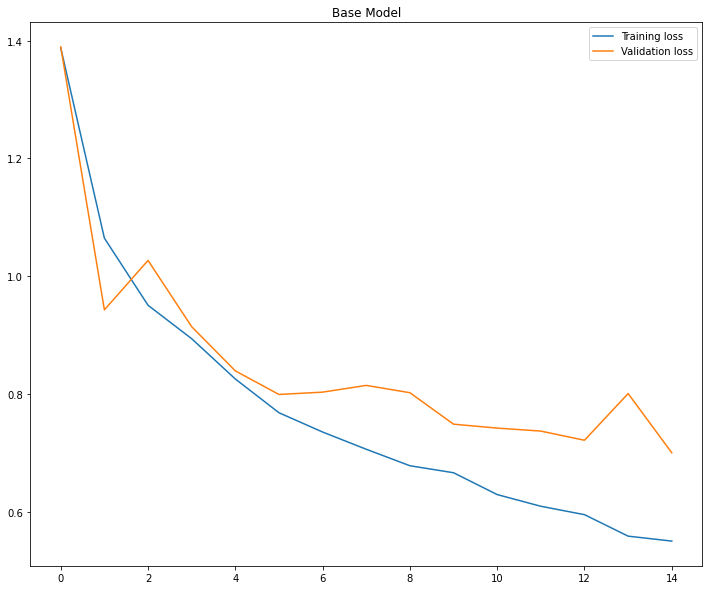

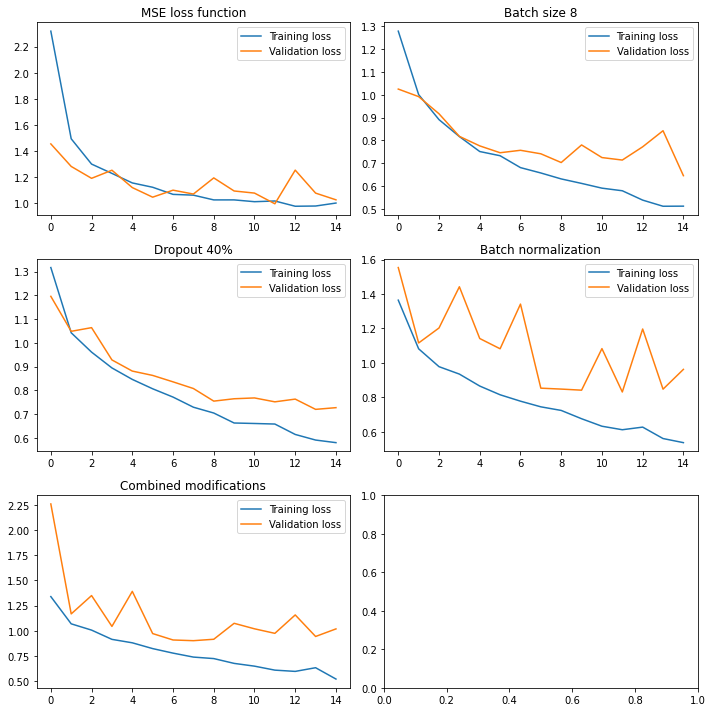

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)

loss_base = history.history['loss']
val_loss_base = history.history['val_loss']

loss_mse = history_msl.history['loss']
val_loss_mse = history_msl.history['val_loss']

loss_drop40 = history_drop40.history['loss']
val_loss_drop40 = history_drop40.history['val_loss']

loss_batch8 = history_batch8.history['loss']
val_loss_batch8 = history_batch8.history['val_loss']

loss_batchNormalization = history_batchNormalization.history['loss']
val_loss_batchNormalization = history_batchNormalization.history['val_loss']

loss_combined = history_combined.history['loss']
val_loss_combined = history_combined.history['val_loss']


plt.figure(figsize=(26.5, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_base, label='Training loss')
plt.plot(epochs_range, val_loss_base, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Base Model')

fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(epochs_range, loss_mse, label='Training loss')
axs[0, 0].plot(epochs_range, val_loss_mse, label='Validation loss')
axs[0, 0].set_title("MSE loss function")
axs[0, 0].legend(loc='upper right')
axs[1, 0].plot(epochs_range, loss_drop40, label='Training loss')
axs[1, 0].plot(epochs_range, val_loss_drop40, label='Validation loss')
axs[1, 0].set_title("Dropout 40%")
axs[1, 0].legend(loc='upper right')
axs[0, 1].plot(epochs_range, loss_batch8, label='Training loss')
axs[0, 1].plot(epochs_range, val_loss_batch8, label='Validation loss')
axs[0, 1].set_title("Batch size 8")
axs[0, 1].legend(loc='upper right')
axs[1, 1].plot(epochs_range, loss_batchNormalization, label='Training loss')
axs[1, 1].plot(epochs_range, val_loss_batchNormalization, label='Validation loss')
axs[1, 1].set_title("Batch normalization")
axs[1, 1].legend(loc='upper right')
axs[2, 0].plot(epochs_range, loss_combined, label='Training loss')
axs[2, 0].plot(epochs_range, val_loss_combined, label='Validation loss')
axs[2, 0].set_title("Combined modifications")
axs[2, 0].legend(loc='upper right')
fig.tight_layout()

## Conclusions

Given the obtained results above of accuracy and loss scores for the training and validation sets. We are now able to compare the results between the base model with each model variation.

<br>

**Base Model:**
 * From the 5th epoch we start to observe signs of overfitting as the difference in accuracy between training and validation begun to increase. However, in the 12th epoch there is less difference between the training and validation accuracies but in the further epochs it starts to increase the differences between them again, not having sure if this disparity will increase in the following epochs. Nevertheless, looking for the absolute values of accuracy between training(0.7933) and validation (0.7425), the difference aren't significative taking into accont that the training set have 2936 imagens and the validation set 734 images.

 * Inferring the plot of the loss metric, the same situation is revealed after the 5th epoch. As the training loss decreases the validation loss increase - showing signs of overfitting.

<br>

**Mean Squared Error (MSE):**
 * We can infer the the model had a worst performance when using the mean squared error as lost function than the base model which uses the Categorical Cross Entropy. Training and validation accuracies were bellow 20% by the 15th epoch.
 * However, observing the results of the loss function plot, it is notorious the decrease of overfitting presence comparing with the base model - the values are much closer to each other and both settle between 1 and 1.5.

<br>

 **Batch Size 8:**
   * The reduction of the batch size from 32 to 8 showed to delay the signs of overfitting - these are now evident from the 8th epoch in terms of accuracy.
   * However, by inferring the loss plot it is noticeable that there was not great differences compared with the base model, also showing signs of overfitting.

<br>

**Dropout 40%:**
  * When increasing the dropout rate to 40%, it is noticeable the reduction of the signs of overfitting, smoothing the curves of the accuracy and loss plots compared with the base model.
  * However, there is still a minor difference between the training and validation set.

<br>

**Batch Normalization:**
  * Observing the accuracy and loss plots, we are able to infer that the curves of the validation set stabilizes between the 6th and 9th epochs and aproaching the training set curve reducing the overfitting ocurrence.
  * However, on the remaining epochs the model demonstrates to be more unstable and worst compared with the base model.

<br>

**Combined Modifications:** 
  * Overall, the model combining the MSE loss function, batch size = 8, dropout = 40% and using batch normalization showed to be more unstable and worst in terms of reducing the overfitting phenomena. Perhaps, due to the use of the MSE as loss function which had previously shown bad results.


<br>

  

# Problem 2

Implement an autoencoder to learn to encode images from the dataset given in Problem 1.

### 2.1 Pre-Processing

In [4]:
# set batch size to 32
batch_size = 32

# image dimentions
img_height = 180
img_width = 180

Train an autoencoder on 3500 images from the image classification dataset, leaving 170
aside for validation:

In [5]:
# set training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=1-(3500/3670),
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 3500 files for training.


In [6]:
# set validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=1-(3500/3670),
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 170 files for validation.


In [7]:
# performance configuration
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
# remove layers
train_ds = np.concatenate([x for x, y in train_ds], axis=0)
val_ds = np.concatenate([x for x, y in val_ds], axis=0)

# convert to tensor
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)


In [10]:
print(train_ds.shape)
print(val_ds.shape)

(3500, 180, 180, 3)
(170, 180, 180, 3)


A)

#### Defining the Convolucional Autoencoder:

In [11]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(180, 180, 3)),
      layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=1),
      layers.MaxPooling2D((2,2), padding="same"),
      layers.Conv2D(16, (4, 4), activation='relu', padding='same', strides=1),
      layers.MaxPooling2D((2,2), padding="same"),
      layers.Conv2D(8, (4, 4), activation='relu', padding='same', strides=1),
      layers.Flatten()])

    self.decoder = tf.keras.Sequential([
      layers.Reshape((45,45,8)),
      layers.Conv2D(8, kernel_size=4, strides=1, activation='relu', padding='same'),
      layers.UpSampling2D((2,2)),
      layers.Conv2D(16, kernel_size=4, strides=1, activation='relu', padding='same'),
      layers.UpSampling2D((2,2)),
      layers.Conv2D(3, kernel_size=(4, 4), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [12]:
# compile the autoencoder with BinaryCrossentropy loss function
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())

In [13]:
# fitting the autoencoder
autoencoder.fit(train_ds, train_ds,
                epochs=10,
                shuffle=True,
                validation_data=(val_ds, val_ds))

Epoch 1/10
110/110 [==============================] - 27s 142ms/step - loss: 0.5730 - val_loss: 0.5105
Epoch 2/10
110/110 [==============================] - 15s 133ms/step - loss: 0.5042 - val_loss: 0.4924
Epoch 3/10
110/110 [==============================] - 15s 133ms/step - loss: 0.4921 - val_loss: 0.4836
Epoch 4/10
110/110 [==============================] - 15s 134ms/step - loss: 0.4874 - val_loss: 0.4820
Epoch 5/10
110/110 [==============================] - 15s 137ms/step - loss: 0.4853 - val_loss: 0.4792
Epoch 6/10
110/110 [==============================] - 15s 133ms/step - loss: 0.4833 - val_loss: 0.4791
Epoch 7/10
110/110 [==============================] - 15s 132ms/step - loss: 0.4827 - val_loss: 0.4771
Epoch 8/10
110/110 [==============================] - 15s 132ms/step - loss: 0.4814 - val_loss: 0.4763
Epoch 9/10
110/110 [==============================] - 15s 133ms/step - loss: 0.4808 - val_loss: 0.4757
Epoch 10/10
110/110 [==============================] - 15s 133ms/step - l

In [14]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        8208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 8)         2056      
                                                                 
 flatten (Flatten)           (None, 16200)             0

In [15]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 45, 45, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 8)         1032      
                                                                 
 up_sampling2d (UpSampling2D  (None, 90, 90, 8)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 16)        2064      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 180, 180, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 3)      

### B) 

Sample 3 examples from each dataset split, the train and validation set, and use the autoencoder to encode and decode the images, comparing them with the original.

In [16]:
# select only 3 images from training and validation set
original_train_3imgs = train_ds[50:53]
original_val_3imgs = val_ds[50:53] 

#### Encode and Decode the training and validation sets

In [17]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
decoded_train_3imgs = autoencoder.decoder(encoded_train_3imgs).numpy()

encoded_val_3imgs = autoencoder.encoder(original_val_3imgs).numpy()
decoded_val_3imgs = autoencoder.decoder(encoded_val_3imgs).numpy()

#### Plot Results

In [18]:
def image_plot(original_imgs, reconstructed_imgs, n):
  plt.figure(figsize = (8,4))
  for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(original_imgs[i].numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(reconstructed_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
  plt.show()


Train set:



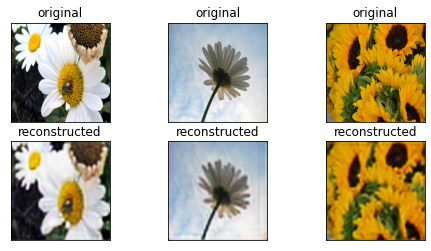


 Validation set:



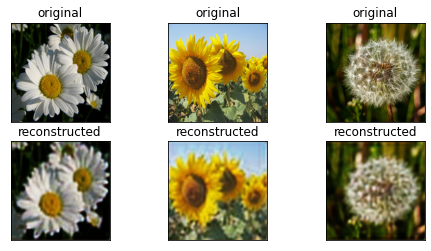

In [19]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs, 3)

The reconstructed images seems to be less sharp compared with the original images.

## C)

Sample 3 examples from each dataset split, the train and validation set, encoding the images
using the Encoder, obtaining the intermediate representations. Using the GaussianNoise
layer, introduce 5%, 10% and 20% noise to the representations. Finally, decode the representations using the Decoder and analyze the obtained images.

### C1) 5% noise

In [20]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
noise5_train = tf.keras.layers.GaussianNoise(0.05)(encoded_train_3imgs,training=True)
decoded_train_3imgs_n5 = autoencoder.decoder(noise5_train).numpy()

encoded_val_3imgs = autoencoder.encoder(original_val_3imgs).numpy()
noise5_val = tf.keras.layers.GaussianNoise(0.05)(encoded_val_3imgs,training=True)
decoded_val_3imgs_n5 = autoencoder.decoder(noise5_val).numpy()

Train set:



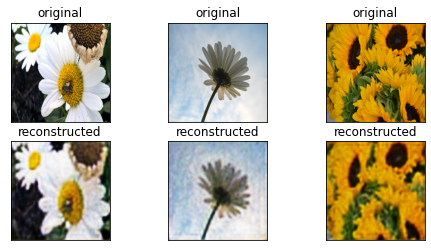


 Validation set:



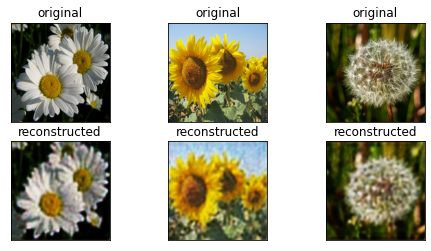

In [21]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n5, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n5, 3)

### C2) 10% noise

In [22]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
noise10_train = tf.keras.layers.GaussianNoise(0.1)(encoded_train_3imgs,training=True)
decoded_train_3imgs_n10 = autoencoder.decoder(noise10_train).numpy()

encoded_val_3imgs = autoencoder.encoder(original_val_3imgs).numpy()
noise10_val = tf.keras.layers.GaussianNoise(0.1)(encoded_val_3imgs,training=True)
decoded_val_3imgs_n10 = autoencoder.decoder(noise10_val).numpy()

Train set:



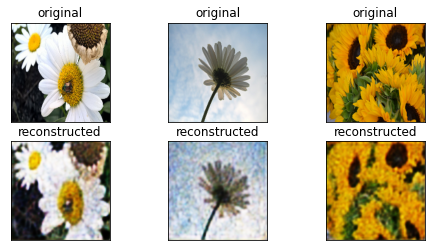


 Validation set:



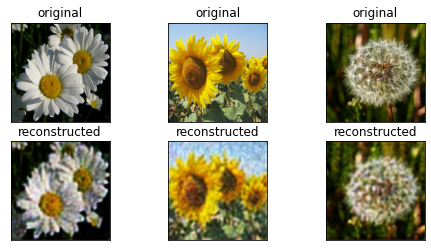

In [23]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n10, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n10, 3)

### C3) 20% noise

In [24]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
noise20_train = tf.keras.layers.GaussianNoise(0.2)(encoded_train_3imgs,training=True)
decoded_train_3imgs_n20 = autoencoder.decoder(noise20_train).numpy()

encoded_val_3imgs = autoencoder.encoder(original_val_3imgs).numpy()
noise20_val = tf.keras.layers.GaussianNoise(0.2)(encoded_val_3imgs,training=True)
decoded_val_3imgs_n20 = autoencoder.decoder(noise20_val).numpy()

Train set:



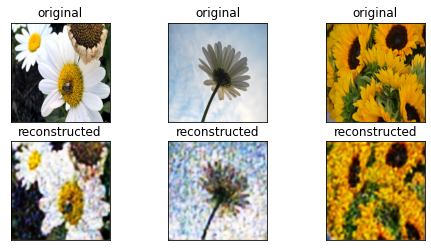


 Validation set:



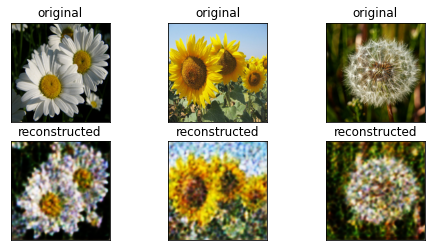

In [25]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n20, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n20, 3)

As long as the noise percentage increases the reconstructed images lose their sharpness and some artifacts appear.

## D) 

### D1) 5% noise

In [26]:
noise5_train = tf.keras.layers.GaussianNoise(0.05)(original_train_3imgs,training=True)
encoded_train_3imgs_n5 = autoencoder.encoder(noise5_train).numpy()
decoded_train_3imgs_n5 = autoencoder.decoder(encoded_train_3imgs_n5).numpy()

noise5_val = tf.keras.layers.GaussianNoise(0.05)(original_val_3imgs,training=True)
encoded_val_3imgs_n5 = autoencoder.encoder(noise5_val).numpy()
decoded_val_3imgs_n5 = autoencoder.decoder(encoded_val_3imgs_n5).numpy()

Train set:



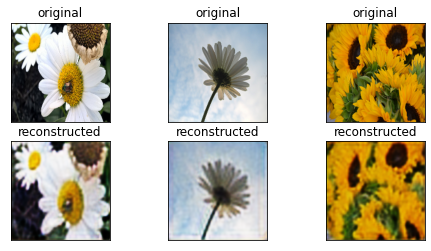


 Validation set:



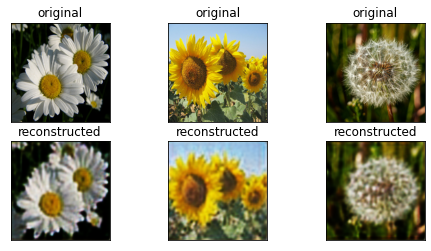

In [27]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n5, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n5, 3)

### D2) 10% noise

In [28]:
noise10_train = tf.keras.layers.GaussianNoise(0.1)(original_train_3imgs,training=True)
encoded_train_3imgs_n10 = autoencoder.encoder(noise10_train).numpy()
decoded_train_3imgs_n10 = autoencoder.decoder(encoded_train_3imgs_n10).numpy()

noise10_val = tf.keras.layers.GaussianNoise(0.1)(original_val_3imgs,training=True)
encoded_val_3imgs_n10 = autoencoder.encoder(noise10_val).numpy()
decoded_val_3imgs_n10 = autoencoder.decoder(encoded_val_3imgs_n10).numpy()

Train set:



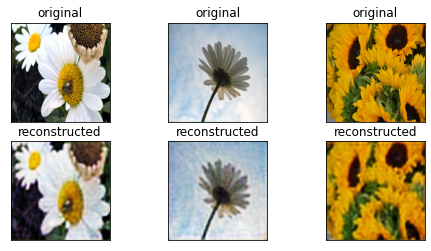


 Validation set:



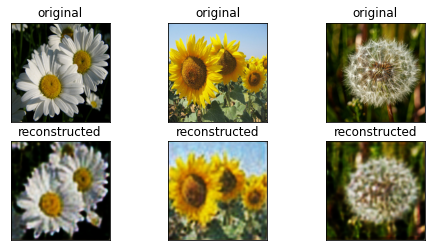

In [29]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n10, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n10, 3)

### D3) 20% noise

In [30]:
noise20_train = tf.keras.layers.GaussianNoise(0.2)(original_train_3imgs,training=True)
encoded_train_3imgs_n20 = autoencoder.encoder(noise20_train).numpy()
decoded_train_3imgs_n20 = autoencoder.decoder(encoded_train_3imgs_n20).numpy()

noise20_val = tf.keras.layers.GaussianNoise(0.2)(original_val_3imgs,training=True)
encoded_val_3imgs_n20 = autoencoder.encoder(noise20_val).numpy()
decoded_val_3imgs_n20 = autoencoder.decoder(encoded_val_3imgs_n20).numpy()

Train set:



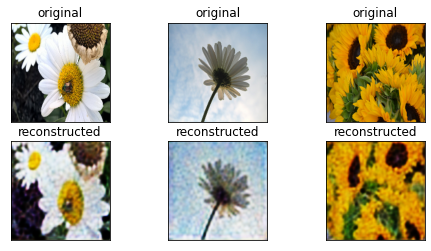


 Validation set:



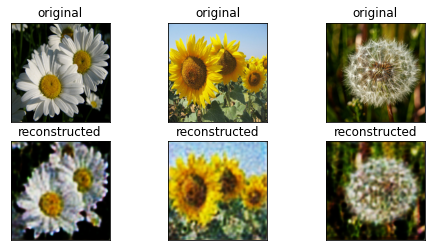

In [31]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n20, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n20, 3)

As long as the noise percentage increases the reconstructed images lose their sharpness, but the appearance of artifacts is smaller compared to the exercise **C)**.